# NZ → China Exports Pipeline (2021–2024)

This notebook is an `.ipynb` version of your script. It:
- Loads Stats NZ OMT HS10 CSVs from the `data/` folder
- Filters China exports and maps HS chapters to sectors (Dairy, Meat, Fruit, Forestry)
- Produces aggregated long + wide datasets
- Runs a small EDA section (trend + correlation plots)
- Trains/compares ARIMA, Prophet (optional), Random Forest, XGBoost (optional), LSTM (optional)

**Before running:**
1. Put your raw CSV files in a folder named `data` in the same directory as this notebook.
2. Run all cells from top to bottom.

Outputs:
- `omt_hs10_china_aggregated.csv`
- `omt_hs10_china_aggregated_wide.csv`
- `out_forecasts/` (plots, forecast CSVs, SHAP summaries, metrics)


In [69]:
# run_pipeline.py
# NZ → China Exports — End-to-End Pipeline with EDA & Forecasts (2021–2024)

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


In [70]:
# ---------------------------
# Config

In [71]:
# ---------------------------
IN_DIR = Path("data")
OUT_FILE_LONG = Path("omt_hs10_china_aggregated.csv")
OUT_FILE_WIDE = Path("omt_hs10_china_aggregated_wide.csv")
OUT_DIR = Path("out_forecasts")
OUT_DIR.mkdir(exist_ok=True)

# Prefer 'total_export_FOB' if present (some Stats NZ extractions include this)
PREFER_TOTAL_EXPORTS = False

# China Manufacturing PMI file (CSV) placed under data/
PMI_FILE = "MPI.csv"


# HS chapter → sector map (your assignment’s 4 sectors)
SECTOR_MAP = {
    "02": "Meat",
    "16": "Meat",
    "04": "Dairy",
    "19": "Dairy",
    "08": "Fruit",
    "20": "Fruit",
    "44": "Forestry",
    "47": "Forestry",
    "48": "Forestry",
}
KEEP_SECTORS = ["Dairy", "Meat", "Fruit", "Forestry"]

In [72]:
# ---------------------------
# Optional model deps (fail-soft)

In [73]:
# ---------------------------
HAVE_PROPHET = True
try:
    from prophet import Prophet
except Exception:
    HAVE_PROPHET = False

HAVE_XGB = True
try:
    from xgboost import XGBRegressor
except Exception:
    HAVE_XGB = False

HAVE_TF = True
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from sklearn.preprocessing import MinMaxScaler
except Exception:
    HAVE_TF = False

HAVE_SHAP = True
try:
    import shap
except Exception:
    HAVE_SHAP = False

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [74]:
# ---------------------------

In [75]:
# Helpers

In [76]:
# ---------------------------
def detect_col(df, candidates, required_name):
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in lower_map:
            return lower_map[cand.lower()]
    raise KeyError(
        f"Missing required column for '{required_name}'. "
        f"Tried {candidates}. Available: {list(df.columns)}"
    )

def pick_exports_column(df: pd.DataFrame, prefer_total: bool) -> str:
    lower_map = {c.lower(): c for c in df.columns}
    ordered = []
    if prefer_total:
        ordered += ["total_export_fob"]
    ordered += ["export_fob", "exports ($nzd fob)", "exports", "value", "total_export_fob"]
    for cand in ordered:
        if cand in lower_map:
            return lower_map[cand]
    raise KeyError(
        "No exports value column found. "
        "Looked for Export_FOB / total_export_FOB / 'Exports ($NZD FOB)' / Exports / Value."
    )

def to_chapter(x):
    if pd.isna(x):
        return np.nan
    s = "".join(ch for ch in str(x) if ch.isdigit())
    return s[:2].zfill(2) if s else np.nan

def infer_sector_from_desc(desc: str):
    if not isinstance(desc, str):
        return None
    d = desc.lower()
    if any(k in d for k in ["milk","dairy","butter","cheese","whey"]): return "Dairy"
    if any(k in d for k in ["meat","beef","bovine","lamb","mutton","pork","swine","offal"]): return "Meat"
    if any(k in d for k in ["fruit","apple","kiwifruit","pear","cherry"]): return "Fruit"
    if any(k in d for k in ["wood","logs","timber","lumber","pulp","sawn"]): return "Forestry"
    return None

def month_floor_to_str(s: pd.Series) -> pd.Series:
    """
    Robustly parse month field and return 'Mon-YYYY' strings.
    Filters out pre-2000 accidents (just to avoid Excel-serial garbage).
    """
    s = pd.Series(s)
    s_str = s.astype(str).str.strip()
    dt = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")

    # 1) 'Mon-YYYY'
    mask = s_str.str.fullmatch(r"[A-Za-z]{3}-\d{4}")
    if mask.any():
        dt.loc[mask] = pd.to_datetime(s_str[mask], format="%b-%Y", errors="coerce")

    # 2) ISO: YYYY-MM-DD
    rem = dt.isna()
    mask = rem & s_str.str.fullmatch(r"\d{4}-\d{2}-\d{2}")
    if mask.any():
        dt.loc[mask] = pd.to_datetime(s_str[mask], format="%Y-%m-%d", errors="coerce")

    # 3) DMY: DD/MM/YYYY
    rem = dt.isna()
    mask = rem & s_str.str.fullmatch(r"\d{2}/\d{2}/\d{4}")
    if mask.any():
        dt.loc[mask] = pd.to_datetime(s_str[mask], format="%d/%m/%Y", errors="coerce")

    # 4) 'YYYY-MM' -> append -01
    rem = dt.isna()
    mask = rem & s_str.str.fullmatch(r"\d{4}-\d{2}")
    if mask.any():
        dt.loc[mask] = pd.to_datetime(s_str[mask] + "-01", format="%Y-%m-%d", errors="coerce")

    # 5) 'YYYYMM'
    rem = dt.isna()
    mask = rem & s_str.str.fullmatch(r"\d{6}")
    if mask.any():
        dt.loc[mask] = pd.to_datetime(s_str[mask], format="%Y%m", errors="coerce")

    # 6) Excel serials (rough guard band)
    rem = dt.isna()
    if rem.any():
        nums = pd.to_numeric(s_str[rem], errors="coerce")
        excel_mask = (nums > 20000) & (nums < 60000)
        if excel_mask.any():
            idx = nums[excel_mask].index
            dt.loc[idx] = pd.to_datetime(nums[excel_mask], unit="d", origin="1899-12-30", errors="coerce")

    # Floor to month and drop silly early dates
    dt = dt.dt.to_period("M").dt.to_timestamp()
    bad = dt.notna() & (dt.dt.year < 2000)
    if bad.any():
        dt.loc[bad] = pd.NaT

    return dt.dt.strftime("%b-%Y")

def load_and_stack(in_dir: Path) -> pd.DataFrame:
    """
    Load ONLY the export CSVs (e.g., 2020_Exports_HS10_by_Country.csv ... 2024_Exports_HS10_by_Country.csv).
    This avoids accidentally stacking MPI.csv or previously-generated output CSVs, which can make WIDE empty.
    """
    export_csvs = sorted([p for p in in_dir.glob("*.csv")
                          if re.search(r"Exports_HS10_by_Country", p.name, flags=re.IGNORECASE)])
    if not export_csvs:
        # Fallback: take year-prefixed files, still excluding MPI/outputs
        export_csvs = sorted([p for p in in_dir.glob("*.csv")
                              if re.match(r"^20\d{2}.*\.csv$", p.name, flags=re.IGNORECASE)
                              and "mpi" not in p.name.lower()
                              and "pmi" not in p.name.lower()
                              and "aggregated" not in p.name.lower()])
    if not export_csvs:
        raise FileNotFoundError(
            f"No export CSV files found in: {in_dir.resolve()}\n"
            "Expected files like '2020_Exports_HS10_by_Country.csv' ... '2024_Exports_HS10_by_Country.csv'."
        )
    print("[INFO] Loading export files:\n - " + "\n - ".join([p.name for p in export_csvs]))
    frames = []
    for p in export_csvs:
        try:
            df = pd.read_csv(p)
        except UnicodeDecodeError:
            df = pd.read_csv(p, encoding="latin-1")
        frames.append(df)
    out = pd.concat(frames, ignore_index=True)
    print("[INFO] Loaded export rows:", len(out), "Columns:", list(out.columns))
    return out

def normalize_and_filter(df: pd.DataFrame, prefer_total: bool) -> pd.DataFrame:
    """
    China-only rows, HS→Sector mapping, numeric exports, month clamp (2021–2024).
    """
    # Column detection
    month_col   = detect_col(df, ["Month","month","Date","Period"], "Month")
    hs_col      = detect_col(df, ["Harmonised System Code","Harmonized System Code","HS Code","HS code","HS_Code","HSCode","hs"], "HS Code")
    partner_col = detect_col(df, ["Partner","Partner Country","Country","Destination","country"], "Partner")
    exports_col = pick_exports_column(df, prefer_total)

    # Optional HS description
    hs_desc_col = None
    for cand in ["hs_desc","HS_Desc","HS Description","hs description","Description"]:
        if cand in df.columns:
            hs_desc_col = cand
            break

    keep_cols = [month_col, hs_col, partner_col, exports_col] + ([hs_desc_col] if hs_desc_col else [])
    df = df[keep_cols].copy()
    df.columns = ["Month","HS","Partner","ExportsNZD"] + (["hs_desc"] if hs_desc_col else [])

    # China only
    df["Partner"] = df["Partner"].astype(str)
    df = df[df["Partner"].str.contains("china", case=False, na=False)]

    # HS → chapter → sector
    df["HS_Chapter"] = df["HS"].apply(to_chapter)
    df["Sector"] = df["HS_Chapter"].map(SECTOR_MAP)
    if "hs_desc" in df.columns:
        miss = df["Sector"].isna()
        if miss.any():
            df.loc[miss, "Sector"] = df.loc[miss, "hs_desc"].apply(infer_sector_from_desc)

    df = df[df["Sector"].isin(KEEP_SECTORS)].copy()

    # Numeric
    if df["ExportsNZD"].dtype == object:
        df["ExportsNZD"] = df["ExportsNZD"].astype(str).str.replace(",", "", regex=False)
    df["ExportsNZD"] = pd.to_numeric(df["ExportsNZD"], errors="coerce").fillna(0.0)

    # Month normalization & window
    df["Month"] = month_floor_to_str(df["Month"])
    parsed = pd.to_datetime(df["Month"], format="%b-%Y", errors="coerce")
    years = parsed.dt.year
    df = df[years.between(2021, 2024, inclusive="both")].copy()

    print("[INFO] Chapters present:", sorted(df["HS_Chapter"].dropna().unique()))
    print("[INFO] Sectors present:", sorted(df["Sector"].dropna().unique()))
    return df

def aggregate(df: pd.DataFrame) -> pd.DataFrame:
    agg = (df.groupby(["Month","HS_Chapter","Sector"], as_index=False)["ExportsNZD"]
             .sum()
             .rename(columns={"ExportsNZD":"Total_Exports_NZD"}))
    dt = pd.to_datetime(agg["Month"], format="%b-%Y", errors="coerce")
    agg = agg.assign(_dt=dt).sort_values(["_dt","HS_Chapter"]).drop(columns="_dt")
    return agg[["Month","HS_Chapter","Sector","Total_Exports_NZD"]]

In [77]:
# ---------------------------

In [78]:
# EDA helpers

In [79]:
# ---------------------------
def small_eda(wide_csv: Path, out_dir: Path):
    print("\n=== SMALL EDA ===")
    wide = pd.read_csv(wide_csv)
    wide_dt = wide.copy()
    wide_dt["Month_dt"] = pd.to_datetime(wide_dt["Month"], format="%b-%Y", errors="coerce")

    # Descriptive stats
    eda_stats = {}
    for col in wide_dt.columns:
        if col not in ["Month", "Month_dt"]:
            eda_stats[col] = wide_dt[col].describe()
    eda_df = pd.DataFrame(eda_stats).round(2)
    print("[EDA] Sector descriptive stats:")
    if not eda_df.empty:
        print(eda_df.to_string())

    # Trend lines
    plt.figure(figsize=(10,6))
    for s in ["Dairy","Meat","Fruit","Forestry"]:
        if s in wide_dt.columns and wide_dt[s].notna().any():
            plt.plot(wide_dt["Month_dt"], wide_dt[s], label=s)
    plt.title("NZ → China Exports by Sector (Monthly, 2021–2024)")
    plt.xlabel("Month"); plt.ylabel("Exports NZD (FOB)")
    plt.xticks(rotation=45); plt.legend(); plt.tight_layout()
    out_dir.mkdir(exist_ok=True)
    plt.savefig(out_dir / "eda_trends.png", dpi=150)
    plt.show()
    plt.close()

    # Correlation
    value_cols = [c for c in wide_dt.columns if c not in ["Month","Month_dt"]]
    if value_cols:
        corr = wide_dt[value_cols].corr().values
        plt.figure(figsize=(6,5))
        plt.imshow(corr, aspect='auto')
        plt.xticks(range(len(value_cols)), value_cols, rotation=45)
        plt.yticks(range(len(value_cols)), value_cols)
        plt.title("Sector Correlation (Pearson)")
        plt.colorbar(label="corr")
        plt.tight_layout()
        plt.savefig(out_dir / "eda_correlation.png", dpi=150)
        plt.show()
        plt.close()

    # Missing values
    na_counts = {c:int(wide_dt[c].isna().sum()) for c in value_cols}
    print("[EDA] Missing values per sector:", na_counts)

In [80]:
# ---------------------------

In [81]:
# Forecasting helpers

In [82]:
# ---------------------------
def train_test_split_series(s: pd.Series, test_h=12):
    train = s.iloc[:-test_h]
    test  = s.iloc[-test_h:]
    return train, test

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / np.clip(y_true, 1e-9, None))).mean() * 100
    return rmse, mae, mape

def make_lags(series: pd.Series, max_lag=12):
    dfX = series.to_frame("y")
    for L in range(1, max_lag+1):
        dfX[f"lag_{L}"] = dfX["y"].shift(L)
    return dfX.dropna()

def residual_intervals(y_true_train, y_pred_train, y_pred_test, z=1.96):
    resid = y_true_train - y_pred_train
    sigma = np.std(resid)
    lower = y_pred_test - z * sigma
    upper = y_pred_test + z * sigma
    return lower, upper

def fit_arima(train, test, order=(2,1,2)):
    m = ARIMA(train, order=order).fit()
    fc = m.get_forecast(steps=len(test))
    mean = pd.Series(fc.predicted_mean, index=test.index, name="ARIMA")
    conf = fc.conf_int(alpha=0.05)
    lower = conf.iloc[:,0].set_axis(test.index)
    upper = conf.iloc[:,1].set_axis(test.index)
    return mean, lower, upper

def fit_prophet(series, test_h=12):
    if not HAVE_PROPHET:
        return None
    dfp = series.reset_index()
    dfp.columns = ["ds","y"]
    train_p = dfp.iloc[:-test_h].copy()
    test_p  = dfp.iloc[-test_h:].copy()
    m = Prophet()
    m.fit(train_p)
    future = m.make_future_dataframe(periods=test_h, freq="MS")
    fcst = m.predict(future)
    tail = fcst.iloc[-test_h:]
    mean  = pd.Series(tail["yhat"].values, index=test_p["ds"], name="Prophet")
    lower = pd.Series(tail["yhat_lower"].values, index=test_p["ds"])
    upper = pd.Series(tail["yhat_upper"].values, index=test_p["ds"])
    return mean, lower, upper

def fit_rf(series, test_h=12, max_lag=12, n_estimators=400, random_state=42, shap_summary=True):
    dfX = make_lags(series, max_lag=max_lag)
    X, y = dfX.drop(columns=["y"]), dfX["y"]
    X_train, X_test = X.iloc[:-test_h], X.iloc[-test_h:]
    y_train, y_test = y.iloc[:-test_h], y.iloc[-test_h:]
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X_train, y_train)
    pred_test = pd.Series(rf.predict(X_test), index=y_test.index, name="RandomForest")
    pred_train = rf.predict(X_train)
    lower, upper = residual_intervals(y_train, pred_train, pred_test.values)
    lower = pd.Series(lower, index=y_test.index)
    upper = pd.Series(upper, index=y_test.index)
    # Optional SHAP
    if shap_summary and HAVE_SHAP:
        try:
            explainer = shap.TreeExplainer(rf)
            shap_values = explainer.shap_values(X_train)
            plt.figure()
            shap.summary_plot(shap_values, X_train, show=False)
            plt.tight_layout()
            plt.savefig(OUT_DIR / "shap_rf_summary.png", dpi=140)
            plt.show()
            plt.close()
        except Exception:
            pass
    return pred_test, lower, upper, rf

def fit_xgb(series, test_h=12, max_lag=12, shap_summary=True):
    if not HAVE_XGB:
        return None
    dfX = make_lags(series, max_lag=max_lag)
    X, y = dfX.drop(columns=["y"]), dfX["y"]
    X_train, X_test = X.iloc[:-test_h], X.iloc[-test_h:]
    y_train, y_test = y.iloc[:-test_h], y.iloc[-test_h:]
    xgb = XGBRegressor(
        n_estimators=500, learning_rate=0.08, max_depth=4,
        subsample=0.9, colsample_bytree=0.9, random_state=42
    )
    xgb.fit(X_train, y_train)
    pred_test = pd.Series(xgb.predict(X_test), index=y_test.index, name="XGBoost")
    pred_train = xgb.predict(X_train)
    lower, upper = residual_intervals(y_train, pred_train, pred_test.values)
    lower = pd.Series(lower, index=y_test.index)
    upper = pd.Series(upper, index=y_test.index)
    if shap_summary and HAVE_SHAP:
        try:
            explainer = shap.TreeExplainer(xgb)
            shap_values = explainer.shap_values(X_train)
            plt.figure()
            shap.summary_plot(shap_values, X_train, show=False)
            plt.tight_layout()
            plt.savefig(OUT_DIR / "shap_xgb_summary.png", dpi=140)
            plt.show()
            plt.close()
        except Exception:
            pass
    return pred_test, lower, upper, xgb

def fit_lstm(series, test_h=12, window=12, epochs=60, batch=8):
    if not HAVE_TF:
        return None
    scaler = MinMaxScaler()
    vals = series.values.reshape(-1,1)
    scaled = scaler.fit_transform(vals)
    X, y = [], []
    for i in range(window, len(scaled)):
        X.append(scaled[i-window:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)
    X_train, X_test = X[:-test_h], X[-test_h:]
    y_train, y_test = y[:-test_h], y[-test_h:]
    model = Sequential([LSTM(64, activation="tanh", input_shape=(window,1)), Dense(1)])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X_train, y_train, epochs=60, batch_size=8, verbose=0)
    pred_test_scaled = model.predict(X_test, verbose=0)
    pred_train_scaled = model.predict(X_train, verbose=0)
    pred_test = scaler.inverse_transform(pred_test_scaled).ravel()
    pred_train = scaler.inverse_transform(pred_train_scaled).ravel()
    y_train_inv = scaler.inverse_transform(y_train).ravel()
    idx_test = series.index[-test_h:]
    pred_series = pd.Series(pred_test, index=idx_test, name="LSTM")
    lower, upper = residual_intervals(y_train_inv, pred_train, pred_test)
    lower = pd.Series(lower, index=idx_test)
    upper = pd.Series(upper, index=idx_test)
    return pred_series, lower, upper, model


def load_pmi_csv(pmi_file: str):
    """Load PMI/MPI CSV and return a monthly (MS) pd.Series indexed by datetime."""
    p = IN_DIR / pmi_file
    if not p.exists():
        print(f"[WARN] PMI file not found at {p.resolve()}. Continuing without PMI.")
        return None
    df = pd.read_csv(p)
    if df.shape[1] < 2:
        print(f"[WARN] PMI file has <2 columns. Continuing without PMI.")
        return None
    df["date"] = pd.to_datetime(df.iloc[:, 0], errors="coerce")
    df["pmi"] = pd.to_numeric(df.iloc[:, 1], errors="coerce")
    df = df.dropna(subset=["date", "pmi"]).set_index("date")["pmi"].sort_index()
    # monthly at month-start, fill gaps
    s = df.resample("MS").mean().interpolate().ffill().bfill()
    print(f"[OK] PMI loaded: {len(s)} points ({s.index.min().date()} → {s.index.max().date()})")
    return s

def make_lags_with_exog(series: pd.Series, exog: pd.Series, max_lag=12, exog_name="PMI", exog_lags=(0,1,2,3)):
    """Create supervised learning features using export lags + exogenous (e.g., PMI) and its lags."""
    dfX = series.to_frame("y")
    for L in range(1, max_lag+1):
        dfX[f"lag_{L}"] = dfX["y"].shift(L)
    if exog is not None:
        ex = exog.reindex(dfX.index).astype(float)
        for L in exog_lags:
            col = f"{exog_name}_lag_{L}"
            dfX[col] = ex.shift(L) if L > 0 else ex
    return dfX.dropna()

def fit_sarimax(train, test, exog_train, exog_test, order=(2,1,2)):
    m = SARIMAX(train, exog=exog_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
    res = m.fit(disp=False)
    fc = res.get_forecast(steps=len(test), exog=exog_test)
    mean = pd.Series(fc.predicted_mean.values, index=test.index, name="SARIMAX_PMI")
    conf = fc.conf_int(alpha=0.05)
    lower = pd.Series(conf.iloc[:,0].values, index=test.index)
    upper = pd.Series(conf.iloc[:,1].values, index=test.index)
    return mean, lower, upper

def fit_prophet_with_regressor(series, exog: pd.Series, test_h=12, reg_name="PMI"):
    if not HAVE_PROPHET:
        return None
    dfp = series.reset_index()
    dfp.columns = ["ds","y"]
    # align regressor by ds
    dfp[reg_name] = exog.reindex(pd.to_datetime(dfp["ds"])).values
    dfp = dfp.dropna(subset=[reg_name])
    if len(dfp) <= test_h + 24:
        return None
    train_p = dfp.iloc[:-test_h].copy()
    test_p  = dfp.iloc[-test_h:].copy()
    m = Prophet()
    m.add_regressor(reg_name)
    m.fit(train_p)
    fcst = m.predict(test_p[["ds", reg_name]])
    mean  = pd.Series(fcst["yhat"].values, index=test_p["ds"], name="Prophet_PMI")
    lower = pd.Series(fcst["yhat_lower"].values, index=test_p["ds"])
    upper = pd.Series(fcst["yhat_upper"].values, index=test_p["ds"])
    return mean, lower, upper


In [83]:
# ---------------------------

In [84]:
# MAIN

[INFO] Loading export files:
 - 2020_Exports_HS10_by_Country.csv
 - 2021_Exports_HS10_by_Country.csv
 - 2022_Exports_HS10_by_Country.csv
 - 2023_Exports_HS10_by_Country.csv
 - 2024_Exports_HS10_by_Country.csv
[INFO] Loaded export rows: 1299078 Columns: ['month', 'hs', 'hs_desc', 'uom', 'country', 'Export_FOB', 'Export_Qty', 'Re_export_FOB', 'Re_export_Qty', 'total_export_FOB', 'total_export_qty', 'status']
[CHECK] Raw month samples: [202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103]
[INFO] Chapters present: ['10', '11', '12', '15', '16', '18', '19', '20', '21', '22', '23', '30', '32', '33', '35', '38', '40', '41', '42', '43', '44', '47', '48', '50', '51', '60', '64', '67', '68', '71', '73', '74', '80', '81', '82', '84', '85', '90', '94', '95', '96']
[INFO] Sectors present: ['Dairy', 'Forestry', 'Fruit', 'Meat']

[DIAG] Sector counts:
Sector
Fruit       3059
Dairy       2176
Forestry    1633
Meat        1485

[DIAG] T

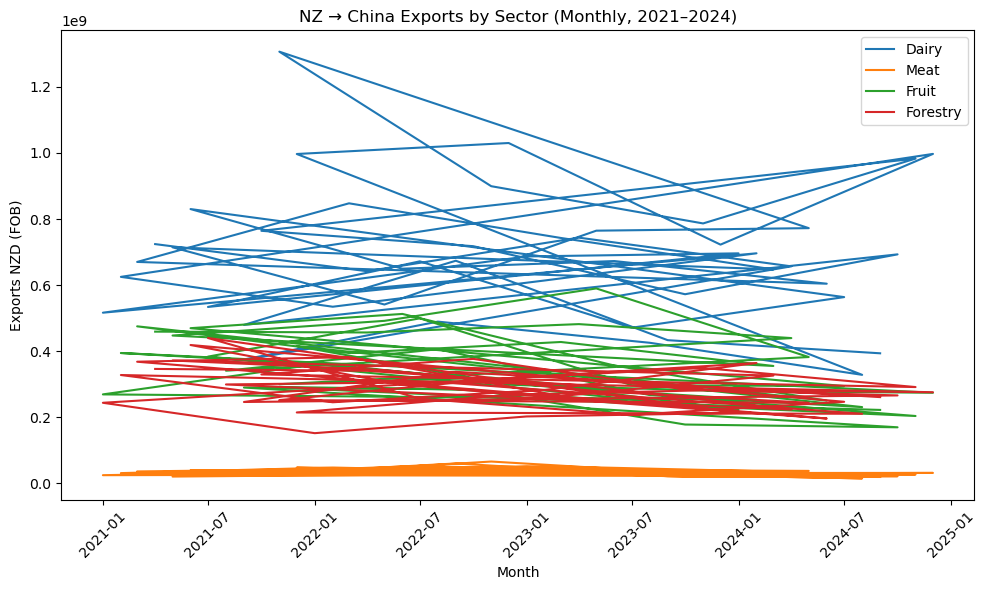

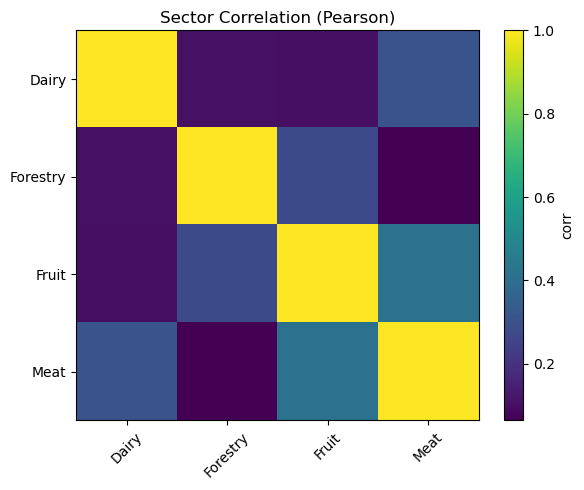

[EDA] Missing values per sector: {'Dairy': 0, 'Forestry': 0, 'Fruit': 0, 'Meat': 0}
[OK] PMI loaded: 50 points (2021-11-01 → 2025-12-01)


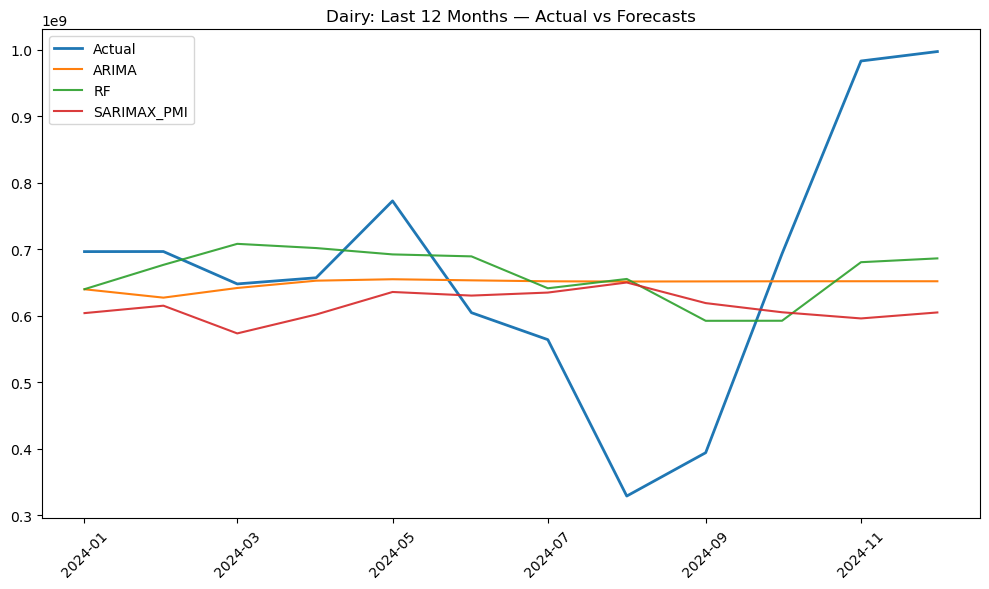

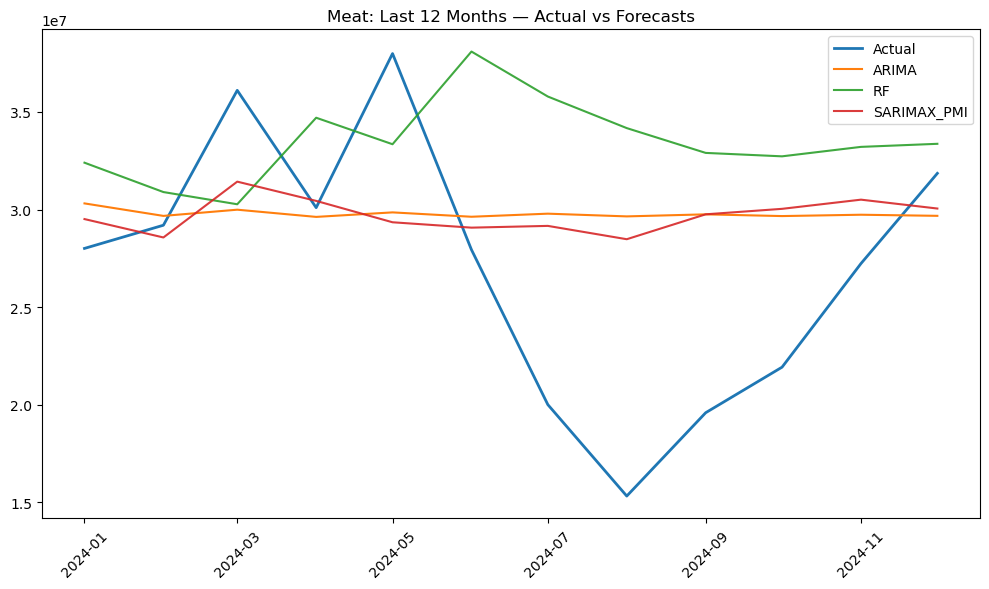

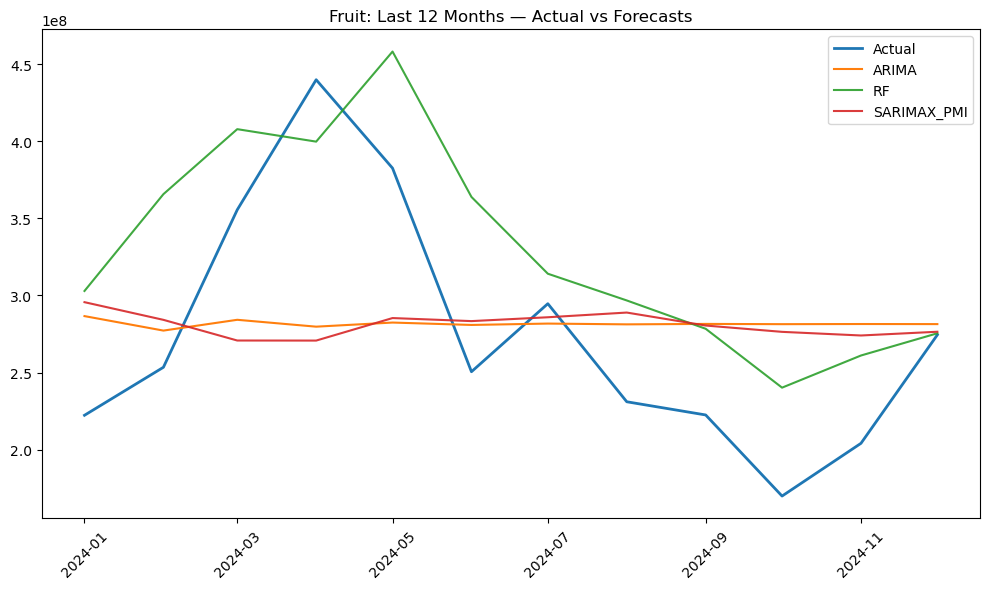

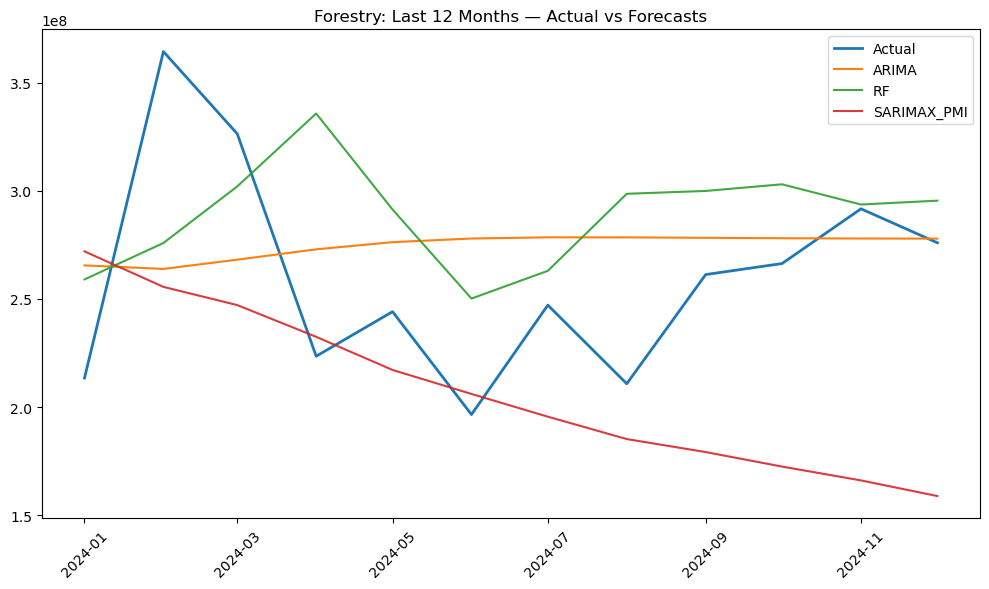


=== Metrics (sorted by RMSE) ===
  Sector       Model         RMSE          MAE      MAPE
   Dairy          RF 1.763892e+08 1.386218e+08 24.291990
   Dairy       ARIMA 1.900325e+08 1.407760e+08 24.708929
   Dairy SARIMAX_PMI 2.069037e+08 1.625956e+08 27.146851
   Dairy     Prophet          NaN          NaN       NaN
   Dairy         XGB          NaN          NaN       NaN
   Dairy        LSTM          NaN          NaN       NaN
   Dairy Prophet_PMI          NaN          NaN       NaN
   Dairy      RF_PMI          NaN          NaN       NaN
   Dairy     XGB_PMI          NaN          NaN       NaN
Forestry       ARIMA 5.204997e+07 4.310942e+07 17.306625
Forestry          RF 5.732412e+07 4.768809e+07 19.537036
Forestry SARIMAX_PMI 7.684571e+07 6.568691e+07 23.897058
Forestry     Prophet          NaN          NaN       NaN
Forestry         XGB          NaN          NaN       NaN
Forestry        LSTM          NaN          NaN       NaN
Forestry Prophet_PMI          NaN          NaN       N

In [85]:
# ---------------------------
def main():
    # Load & normalize
    raw = load_and_stack(IN_DIR)

    try:
        raw_month_col = detect_col(raw, ["Month","month","Date","Period"], "Month")
        print("[CHECK] Raw month samples:", raw[raw_month_col].drop_duplicates().head(15).tolist())
    except Exception as e:
        print("[CHECK] Could not sample raw months:", e)

    norm = normalize_and_filter(raw, PREFER_TOTAL_EXPORTS)

    print("\n[DIAG] Sector counts:")
    print(norm["Sector"].value_counts(dropna=False).to_string())

    print("\n[DIAG] Totals by HS_Chapter (China only):")
    print(norm.groupby("HS_Chapter")["ExportsNZD"].sum().sort_values(ascending=False).to_string())

    # Aggregate (Month–HS_Chapter–Sector)
    out = aggregate(norm)

    # Write LONG file
    out.to_csv(OUT_FILE_LONG, index=False)
    print(f"[OK] wrote LONG: {OUT_FILE_LONG.resolve()}")

    # FIX: collapse to Month–Sector totals BEFORE pivot (avoid duplicate Month–Sector)
    dup_diag = out.groupby(["Month","Sector"]).size().reset_index(name="rows_per_pair")
    multi = dup_diag[dup_diag["rows_per_pair"] > 1]
    if not multi.empty:
        print(f"[INFO] Found {len(multi)} Month–Sector combos across multiple HS chapters. Summing them.")

    out_ms = out.groupby(["Month","Sector"], as_index=False)["Total_Exports_NZD"].sum()

    # Safe pivot (Month × Sector)
    wide = out_ms.pivot(index="Month", columns="Sector", values="Total_Exports_NZD").reset_index()

    # Write WIDE file
    wide.to_csv(OUT_FILE_WIDE, index=False)
    print(f"[OK] wrote WIDE: {OUT_FILE_WIDE.resolve()}")

    # Diagnostics
    dt_out = pd.to_datetime(out["Month"], format="%b-%Y", errors="coerce")
    print("[CHECK] LONG month range:", dt_out.min(), "→", dt_out.max())
    print("[CHECK] WIDE shape:", wide.shape)
    print("[CHECK] WIDE columns:", list(wide.columns))

    # EDA
    small_eda(OUT_FILE_WIDE, OUT_DIR)

    # Forecasting
    pmi_series = load_pmi_csv(PMI_FILE)
    forecast_all(wide, pmi_series=pmi_series, test_h=TEST_HORIZON_MONTHS if "TEST_HORIZON_MONTHS" in globals() else 12)

def forecast_all(wide_df: pd.DataFrame, test_h: int = 12, pmi_series: pd.Series = None):
    # Use the in-memory WIDE (produced in main) to avoid file/path issues
    if wide_df is None or len(wide_df) == 0:
        raise RuntimeError("WIDE dataframe is empty. Check China filter + SECTOR_MAP + aggregation step.")

    wide_dt = wide_df.copy()

    # If Month is a column (because of reset_index), set it as index
    if "Month" in wide_dt.columns:
        wide_dt["Month"] = pd.to_datetime(wide_dt["Month"], errors="coerce")
        wide_dt = wide_dt.dropna(subset=["Month"]).set_index("Month")

    # Ensure monthly frequency index
    wide_dt = wide_dt.sort_index()
    wide_dt.index = pd.to_datetime(wide_dt.index, format="%b-%Y", errors="coerce")
    wide_dt = wide_dt.sort_index()

    sectors_all = ["Dairy","Meat","Fruit","Forestry"]
    present = [s for s in sectors_all if s in wide_dt.columns and wide_dt[s].notna().any()]
    if not present:
        raise RuntimeError(
            "No target sectors (Dairy/Meat/Fruit/Forestry) found after filtering.\n"
            f"Available columns: {list(wide_dt.columns)}"
        )
    missing = [s for s in sectors_all if s not in present]
    if missing:
        print(f"[WARN] Missing sectors: {missing}. Proceeding with: {present}")

    rows = []
    for sector in present:
        s = wide_dt[sector].asfreq("MS").fillna(0.0)
        exog = None
        if pmi_series is not None:
            exog = pmi_series.reindex(s.index).interpolate().ffill().bfill()

        train, test = train_test_split_series(s, test_h=test_h)

        # ARIMA
        arima_pred, arima_lo, arima_hi = fit_arima(train, test, order=(2,1,2))
        arima_rmse, arima_mae, arima_mape = metrics(test.values, arima_pred.values)


        # SARIMAX with PMI (optional)
        if exog is not None:
            # restrict to months where PMI is available (avoid leakage / NaNs)
            s_p = s.copy()
            ex_p = exog.copy()
            mask = ex_p.notna()
            s_p = s_p.loc[mask]
            ex_p = ex_p.loc[mask]
            if len(s_p) > test_h + 24:
                train_p, test_p = train_test_split_series(s_p, test_h=test_h)
                ex_train, ex_test = ex_p.loc[train_p.index], ex_p.loc[test_p.index]
                try:
                    sx_pred, sx_lo, sx_hi = fit_sarimax(train_p, test_p, ex_train, ex_test, order=(2,1,2))
                    sx_rmse, sx_mae, sx_mape = metrics(test_p.values, sx_pred.values)
                except Exception:
                    sx_pred = sx_lo = sx_hi = None
                    sx_rmse = sx_mae = sx_mape = np.nan
            else:
                sx_pred = sx_lo = sx_hi = None
                sx_rmse = sx_mae = sx_mape = np.nan
        else:
            sx_pred = sx_lo = sx_hi = None
            sx_rmse = sx_mae = sx_mape = np.nan

        # Prophet (optional)
        if HAVE_PROPHET:
            pr = fit_prophet(s, test_h=test_h)
            if pr is not None:
                prophet_pred, prophet_lo, prophet_hi = pr
                prophet_rmse, prophet_mae, prophet_mape = metrics(test.values, prophet_pred.values)
            else:
                prophet_pred = prophet_lo = prophet_hi = None
                prophet_rmse = prophet_mae = prophet_mape = np.nan
        else:
            prophet_pred = prophet_lo = prophet_hi = None
            prophet_rmse = prophet_mae = prophet_mape = np.nan

        
        # Prophet with PMI regressor (optional)
        if HAVE_PROPHET and exog is not None:
            prx = fit_prophet_with_regressor(s, exog, test_h=test_h, reg_name="PMI")
            if prx is not None:
                prophetx_pred, prophetx_lo, prophetx_hi = prx
                # align to test window (may start later due PMI availability)
                # compute metrics against matching actuals
                actual_px = s.reindex(prophetx_pred.index)
                prophetx_rmse, prophetx_mae, prophetx_mape = metrics(actual_px.values, prophetx_pred.values)
            else:
                prophetx_pred = prophetx_lo = prophetx_hi = None
                prophetx_rmse = prophetx_mae = prophetx_mape = np.nan
        else:
            prophetx_pred = prophetx_lo = prophetx_hi = None
            prophetx_rmse = prophetx_mae = prophetx_mape = np.nan

        # Random Forest (+ SHAP)

        rf_pred, rf_lo, rf_hi, _rf = fit_rf(s, test_h=test_h, shap_summary=True)
        rf_rmse, rf_mae, rf_mape = metrics(test.values, rf_pred.values)

        # RF with PMI features (optional)
        if exog is not None:
            dfX_p = make_lags_with_exog(s, exog, max_lag=12, exog_name="PMI", exog_lags=(0,1,2,3))
            Xp, yp = dfX_p.drop(columns=["y"]), dfX_p["y"]
            if len(dfX_p) > test_h + 24:
                Xp_train, Xp_test = Xp.iloc[:-test_h], Xp.iloc[-test_h:]
                yp_train, yp_test = yp.iloc[:-test_h], yp.iloc[-test_h:]
                rf_pmi = RandomForestRegressor(n_estimators=400, random_state=42)
                rf_pmi.fit(Xp_train, yp_train)
                rf_pmi_pred = pd.Series(rf_pmi.predict(Xp_test), index=yp_test.index, name="RF_PMI")
                rf_pmi_rmse, rf_pmi_mae, rf_pmi_mape = metrics(yp_test.values, rf_pmi_pred.values)
            else:
                rf_pmi_pred = None
                rf_pmi_rmse = rf_pmi_mae = rf_pmi_mape = np.nan
        else:
            rf_pmi_pred = None
            rf_pmi_rmse = rf_pmi_mae = rf_pmi_mape = np.nan
            rf_pmi_rmse = rf_pmi_mae = rf_pmi_mape = np.nan

        # XGBoost (optional)
        if HAVE_XGB:

            xgbo = fit_xgb(s, test_h=test_h, shap_summary=True)
            if xgbo is not None:
                xgb_pred, xgb_lo, xgb_hi, _xgb = xgbo
                xgb_rmse, xgb_mae, xgb_mape = metrics(test.values, xgb_pred.values)
            else:
                xgb_pred = xgb_lo = xgb_hi = None
                xgb_rmse = xgb_mae = xgb_mape = np.nan
        else:
            xgb_pred = xgb_lo = xgb_hi = None
            xgb_rmse = xgb_mae = xgb_mape = np.nan


        # XGBoost with PMI features (optional)
        if HAVE_XGB and exog is not None:
            dfX_p = make_lags_with_exog(s, exog, max_lag=12, exog_name="PMI", exog_lags=(0,1,2,3))
            Xp, yp = dfX_p.drop(columns=["y"]), dfX_p["y"]
            if len(dfX_p) > test_h + 24:
                Xp_train, Xp_test = Xp.iloc[:-test_h], Xp.iloc[-test_h:]
                yp_train, yp_test = yp.iloc[:-test_h], yp.iloc[-test_h:]
                xgb_pmi = XGBRegressor(
                    n_estimators=500, learning_rate=0.08, max_depth=4,
                    subsample=0.9, colsample_bytree=0.9, random_state=42
                )
                xgb_pmi.fit(Xp_train, yp_train)
                xgb_pmi_pred = pd.Series(xgb_pmi.predict(Xp_test), index=yp_test.index, name="XGB_PMI")
                xgb_pmi_rmse, xgb_pmi_mae, xgb_pmi_mape = metrics(yp_test.values, xgb_pmi_pred.values)
            else:
                xgb_pmi_pred = None
                xgb_pmi_rmse = xgb_pmi_mae = xgb_pmi_mape = np.nan
        else:
            xgb_pmi_pred = None
            xgb_pmi_rmse = xgb_pmi_mae = xgb_pmi_mape = np.nan

        # LSTM (optional)
        if HAVE_TF:
            lstmo = fit_lstm(s, test_h=test_h, window=12, epochs=60, batch=8)
            if lstmo is not None:
                lstm_pred, lstm_lo, lstm_hi, _lstm = lstmo
                lstm_rmse, lstm_mae, lstm_mape = metrics(test.values, lstm_pred.values)
            else:
                lstm_pred = lstm_lo = lstm_hi = None
                lstm_rmse = lstm_mae = lstm_mape = np.nan
        else:
            lstm_pred = lstm_lo = lstm_hi = None
            lstm_rmse = lstm_mae = lstm_mape = np.nan

        rows += [
            {"Sector": sector, "Model":"ARIMA",        "RMSE":arima_rmse,   "MAE":arima_mae,   "MAPE":arima_mape},
            {"Sector": sector, "Model":"Prophet",      "RMSE":prophet_rmse, "MAE":prophet_mae, "MAPE":prophet_mape},
            {"Sector": sector, "Model":"RF",           "RMSE":rf_rmse,      "MAE":rf_mae,      "MAPE":rf_mape},
            {"Sector": sector, "Model":"XGB",          "RMSE":xgb_rmse,     "MAE":xgb_mae,     "MAPE":xgb_mape},
            {"Sector": sector, "Model":"LSTM",         "RMSE":lstm_rmse,    "MAE":lstm_mae,    "MAPE":lstm_mape},
            {"Sector": sector, "Model":"SARIMAX_PMI",  "RMSE":sx_rmse,      "MAE":sx_mae,      "MAPE":sx_mape},
            {"Sector": sector, "Model":"Prophet_PMI",  "RMSE":prophetx_rmse,"MAE":prophetx_mae,"MAPE":prophetx_mape},
            {"Sector": sector, "Model":"RF_PMI",       "RMSE":rf_pmi_rmse,  "MAE":rf_pmi_mae,  "MAPE":rf_pmi_mape},
            {"Sector": sector, "Model":"XGB_PMI",      "RMSE":xgb_pmi_rmse, "MAE":xgb_pmi_mae, "MAPE":xgb_pmi_mape},
        ]


        # Save forecasts per sector
        out_df = pd.DataFrame({"Actual": test})
        out_df["ARIMA"] = arima_pred
        out_df["ARIMA_lo95"] = arima_lo
        out_df["ARIMA_hi95"] = arima_hi
        if sx_pred is not None:
            out_df["SARIMAX_PMI"] = sx_pred.reindex(out_df.index)
            out_df["SARIMAX_PMI_lo95"] = sx_lo.reindex(out_df.index)
            out_df["SARIMAX_PMI_hi95"] = sx_hi.reindex(out_df.index)
        if "prophet_pred" in locals() and prophet_pred is not None:
            out_df["Prophet"] = prophet_pred.reindex(out_df.index)
            out_df["Prophet_lo95"] = prophet_lo.reindex(out_df.index)
            out_df["Prophet_hi95"] = prophet_hi.reindex(out_df.index)
        if prophetx_pred is not None:
            out_df["Prophet_PMI"] = prophetx_pred.reindex(out_df.index)
        out_df["RF"] = rf_pred
        out_df["RF_lo95"] = rf_lo
        out_df["RF_hi95"] = rf_hi
        if rf_pmi_pred is not None:
            out_df["RF_PMI"] = rf_pmi_pred.reindex(out_df.index)
        if "xgb_pred" in locals() and xgb_pred is not None:
            out_df["XGB"] = xgb_pred
            out_df["XGB_lo95"] = xgb_lo
            out_df["XGB_hi95"] = xgb_hi
        if xgb_pmi_pred is not None:
            out_df["XGB_PMI"] = xgb_pmi_pred.reindex(out_df.index)
        if "lstm_pred" in locals() and lstm_pred is not None:
            out_df["LSTM"] = lstm_pred
            out_df["LSTM_lo95"] = lstm_lo
            out_df["LSTM_hi95"] = lstm_hi

        OUT_DIR.mkdir(exist_ok=True)
        out_df.to_csv(OUT_DIR / f"forecasts_{sector}.csv")

        # Plot
        plt.figure(figsize=(10,6))
        plt.plot(out_df.index, out_df["Actual"].values, label="Actual", linewidth=2)
        plt.plot(out_df.index, out_df["ARIMA"].values, label="ARIMA")
        if "Prophet" in out_df.columns:
            plt.plot(out_df.index, out_df["Prophet"].values, label="Prophet", alpha=0.9)
        plt.plot(out_df.index, out_df["RF"].values, label="RF", alpha=0.9)
        if "SARIMAX_PMI" in out_df.columns:
            plt.plot(out_df.index, out_df["SARIMAX_PMI"].values, label="SARIMAX_PMI", alpha=0.9)
        if "Prophet_PMI" in out_df.columns:
            plt.plot(out_df.index, out_df["Prophet_PMI"].values, label="Prophet_PMI", alpha=0.9)
        if "RF_PMI" in out_df.columns:
            plt.plot(out_df.index, out_df["RF_PMI"].values, label="RF_PMI", alpha=0.9)
        if "XGB" in out_df.columns:
            plt.plot(out_df.index, out_df["XGB"].values, label="XGB", alpha=0.9)
        if "XGB_PMI" in out_df.columns:
            plt.plot(out_df.index, out_df["XGB_PMI"].values, label="XGB_PMI", alpha=0.9)
        if "LSTM" in out_df.columns:
            plt.plot(out_df.index, out_df["LSTM"].values, label="LSTM", alpha=0.9)
        plt.title(f"{sector}: Last 12 Months — Actual vs Forecasts")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.savefig(OUT_DIR / f"plot_{sector}.png", dpi=150)
        plt.show()
        plt.close()

    # Metrics table and winners
    metrics_df = pd.DataFrame(rows)
    if metrics_df.empty:
        raise RuntimeError(
            "No metrics were produced (rows is empty). "
            "Likely no sectors had usable data after filters.\n"
            "Check 'omt_hs10_china_aggregated_wide.csv'."
        )
    metrics_df = metrics_df.sort_values(["Sector","RMSE"])
    OUT_DIR.mkdir(exist_ok=True)
    metrics_df.to_csv(OUT_DIR / "model_results.csv", index=False)
    print("\n=== Metrics (sorted by RMSE) ===")
    print(metrics_df.to_string(index=False))

    winners = metrics_df.loc[metrics_df.groupby("Sector")["RMSE"].idxmin()].reset_index(drop=True)
    print("\n=== Per-sector winners ===")
    print(winners.to_string(index=False))

    for _, row in winners.iterrows():
        s, model, rmse, mae, mape = row["Sector"], row["Model"], row["RMSE"], row["MAE"], row["MAPE"]
        print(f"- {s}: {model} lowest RMSE ({rmse:,.0f}), MAE {mae:,.0f}, MAPE {mape:.2f}%.")


if __name__ == "__main__":
    main()